# Linear Distribution Optimal Power Flow (LinDistFlow)

This research is to meant to demonstrate the OEDI SI use case for distributed optimal power flow (DOPF). The goal was to formulate the optimal power flow problem in the distribution system for active and reactive power setpoints of PV systems using topology information and voltage measurements. The co-simulation runs every 15 minutes as outlined within the scenario file for the given feeder configuration.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from oedisi.componentframework import wiring_diagram_utils
from post_process import plotter

ROOT = os.getcwd()
OUTPUTS = f"{ROOT}/outputs"
SCENARIO_DIR, SCENARIOS, _ = next(os.walk(f'{ROOT}/scenario/'))

print(SCENARIO_DIR)
for idx, scenario in enumerate(SCENARIOS):
    print(idx, scenario)


/home/tylor/dev/oedisi_dopf/scenario/
0 omoo_medium_extreme
1 small_extreme
2 medium_extreme
3 ieee123_update
4 omoo_small
5 small
6 omoo_medium
7 ekf_ieee123
8 omoo
9 medium_medium
10 large
11 medium_high
12 ieee123
13 medium_low
14 small_medium
15 small_low
16 lest_small
17 medium
18 small_high
19 lest_ieee123
20 lest_test


## Select a scenario
Set the SCENARIOS index value from the available scenarios

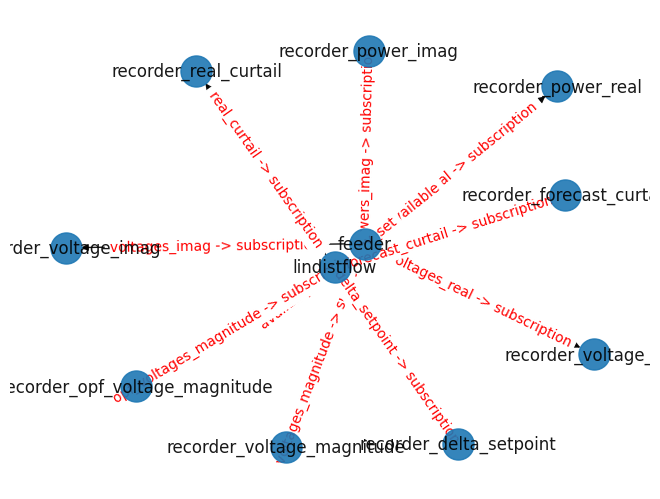

In [2]:
index = 3
SCENARIO = SCENARIOS[index]

path = f"{SCENARIO_DIR}{SCENARIO}"
with open(f"{path}/system.json") as f:
    wiring_diagram = wiring_diagram_utils.WiringDiagram.parse_obj(json.load(f))

wiring_diagram_utils.plot_graph_matplotlib(wiring_diagram)


## Build the selected scenario
The build will create a new build_<scenario> folder and copy over the federate files as specified. Assume successful build if no errors are presented.

In [12]:
os.system(f"oedisi build --system {path}/system.json --component-dict {path}/components.json --target-directory build_{SCENARIO}") 

Loading the components defined in /home/tylor/dev/oedisi_dopf/scenario/medium_medium/components.json
Loading system json /home/tylor/dev/oedisi_dopf/scenario/medium_medium/system.json
Building system in build_medium_medium


0

## Run selected scenario
The simulation will take 5-30 minutes to run depending on the scenario. The results will print Done once complete.

In [13]:
os.system("pkill -9 helics_broker")
os.system(f"oedisi run --runner build_{SCENARIO}/system_runner.json")

[warn] helics-cli's web interface is not installed. You may want to run `pip install "helics[cli]"`.
[warn] helics-cli's observer functionality is not installed. You may want to run `pip install "helics[cli]"`.
[info] Running federation: medium_medium
[info] Running federate recorder_power_real as a background process
[info] Running federate recorder_power_imag as a background process
[info] Running federate recorder_voltage_real as a background process
[info] Running federate recorder_voltage_imag as a background process
[info] Running federate recorder_voltage_magnitude as a background process
[info] Running federate recorder_opf_voltage_magnitude as a background process
[info] Running federate recorder_delta_setpoint as a background process
[info] Running federate recorder_forecast_curtail as a background process
[info] Running federate recorder_real_curtail as a background process
[info] Running federate feeder as a background process
[info] Running federate lindistflow as a backgr

0

## Plot data

In [3]:
if SCENARIO in ["ieee123", "ieee123_update"]:
    root = "150"
    seperator = "    "
    coordsys = "2D"
    annotate = True
    ymin = 0.98
    ymax = 1.06
    alg = "LinDistFlow"

elif SCENARIO in ["small", "small_low", "small_medium", "small_high", "small_extreme"]:
    root = "P1UDT942-P1UHS0_1247X"
    seperator = " "
    coordsys = "GEO"
    annotate = False
    ymin = 1.02
    ymax = 1.035
    alg = "LinDistFlow"

elif SCENARIO in ["medium", "medium_low", "medium_medium", "medium_high", "medium_extreme"]:
    root = "P6UDT5293-P6UHS10_1247X"
    seperator = " "
    coordsys = "GEO"
    annotate = False
    ymin = 1.01
    ymax = 1.05
    alg = "LinDistFlow"

elif SCENARIO == "medium_extreme":
    root = "P6UDT5293-P6UHS10_1247X"
    seperator = " "
    coordsys = "GEO"
    annotate = False
    ymin = 1.01
    ymax = 1.05
    alg = "LinDistFlow"

elif SCENARIO == "omoo_medium_extreme":
    root = "P6UDT5293-P6UHS10_1247X"
    seperator = " "
    coordsys = "GEO"
    annotate = False
    ymin = 1.01
    ymax = 1.05
    alg = "LinDistFlow"

elif SCENARIO == "omoo":
    root = "150"
    seperator = "    "
    coordsys = "2D"
    annotate = True
    ymin = 0.98
    ymax = 1.06
    alg = "OMOO"

elif SCENARIO == "omoo_small":
    root = "P1UDT942-P1UHS0_1247X"
    seperator = " "
    coordsys = "GEO"
    annotate = False
    ymin = 1.02
    ymax = 1.035
    alg = "OMOO"

elif SCENARIO == "omoo_medium":
    root = "P6UDT5293-P6UHS10_1247X"
    seperator = " "
    coordsys = "GEO"
    annotate = False
    ymin = 1.01
    ymax = 1.05
    alg = "OMOO"

else:
    print(f"{SCENARIO} not found")

# Directory location
directory = f"{OUTPUTS}/{SCENARIO}"
topology_filepath = os.path.join(directory, "topology.json")
buscoord_filepath = os.path.join(directory, "BusCoords.dat")
real_voltage_filepath = os.path.join(directory, "voltage_real.feather")
imag_voltage_filepath = os.path.join(directory, "voltage_imag.feather")
opf_voltage_filepath = os.path.join(directory, "opf_voltage_mag.feather")
real_curtail_filepath = os.path.join(directory, "real_curtail.feather")
forecast_curtail_filepath = os.path.join(directory, "forecast_curtail.feather")
time=["07:30", "12:30", "15:30"]

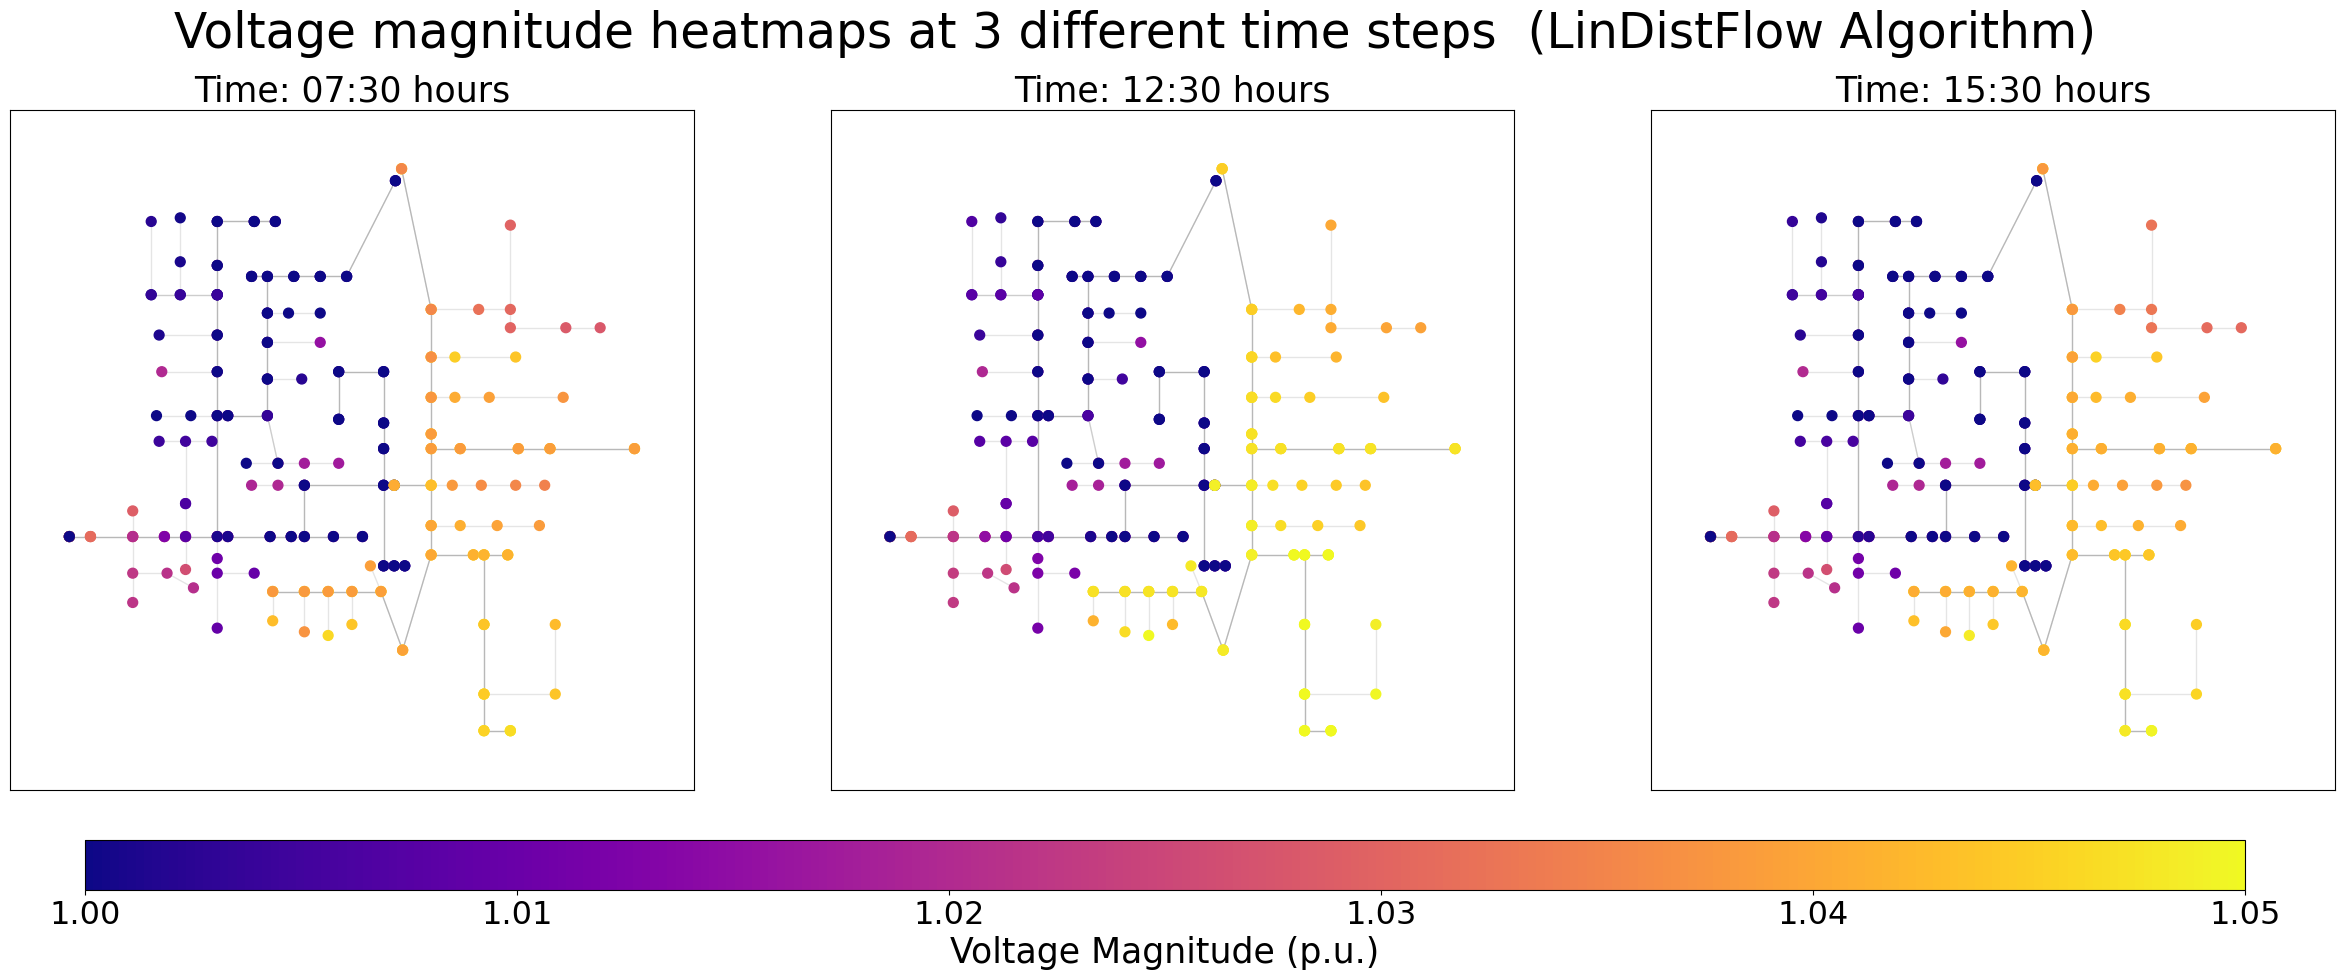

In [5]:
fig_filename = os.path.join(directory, f"network.png")
plotter.plot_network(
    topology_filepath,
    buscoord_filepath,
    real_voltage_filepath,
    imag_voltage_filepath,
    root_node=root, sep=seperator,
    time=time, node_size=50,
    show=True, to_file=fig_filename,
    suptitle_sfx=f"({alg} Algorithm)",
)


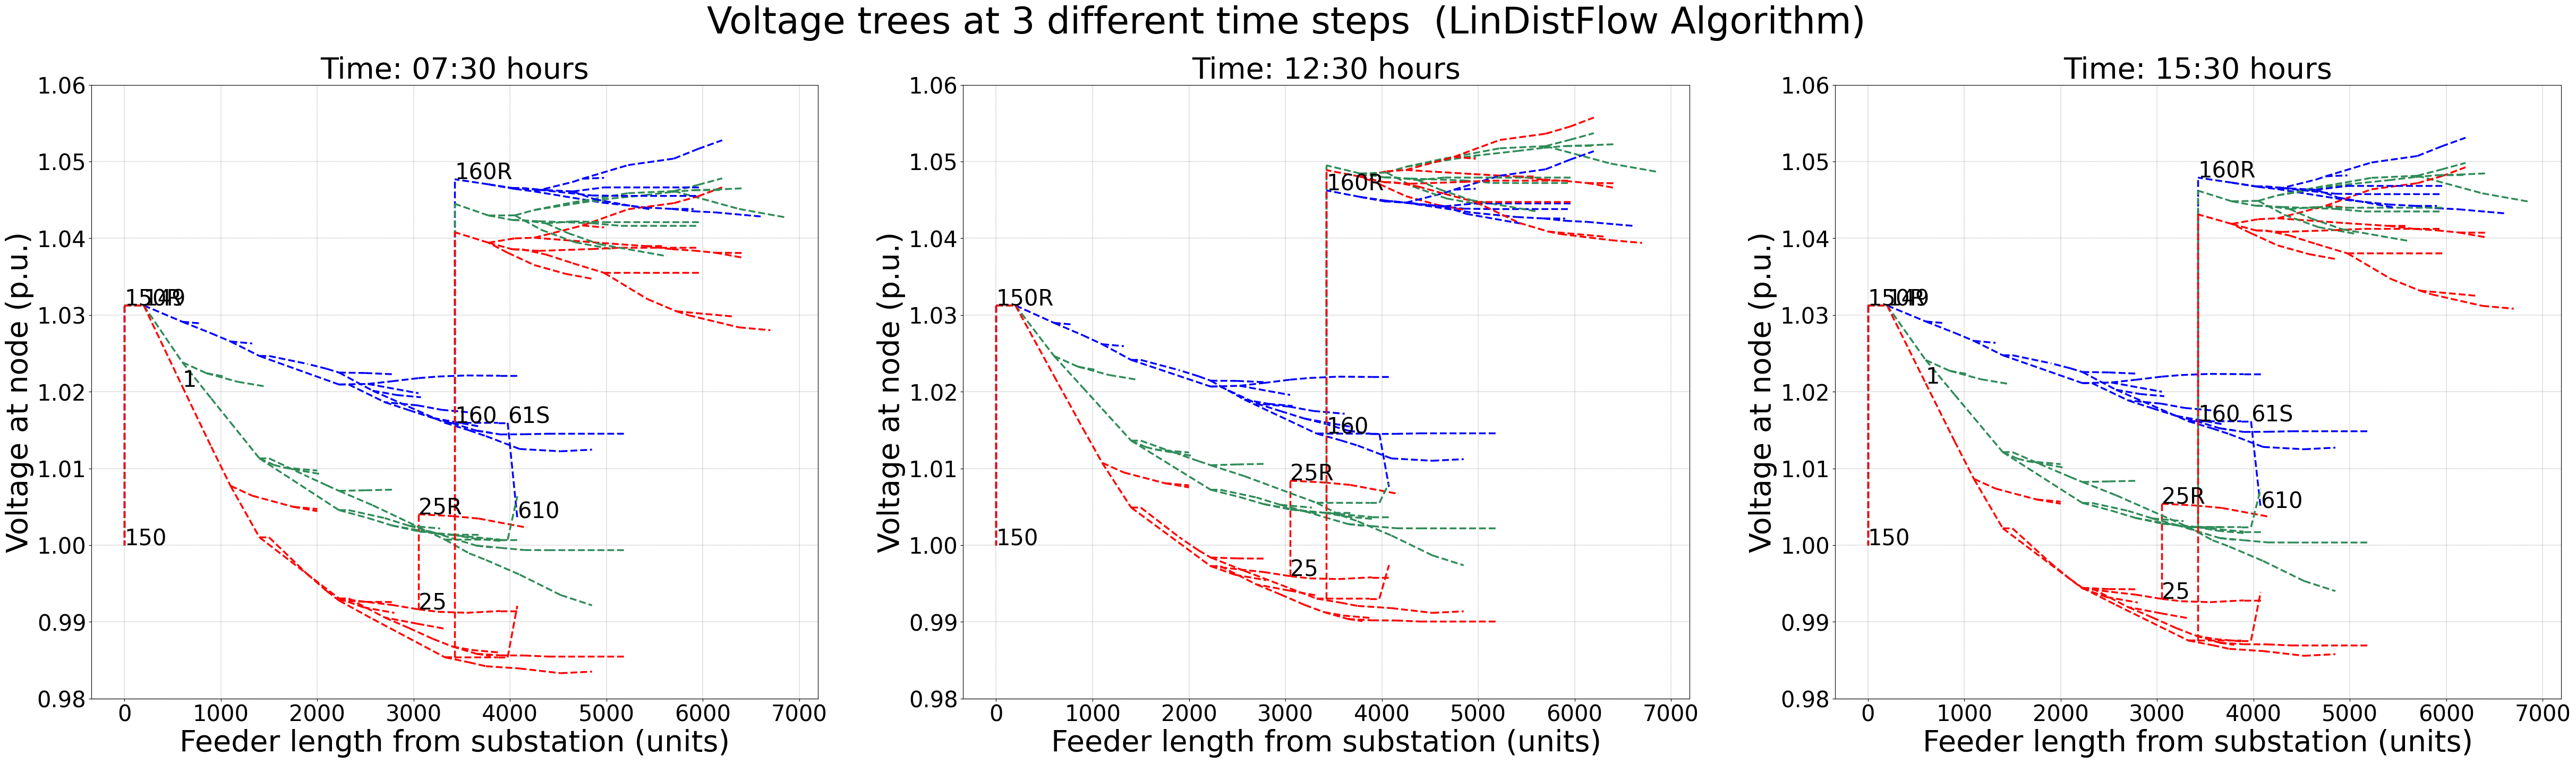

In [6]:
fig_filename = os.path.join(directory, f"vtree.png")
plotter.plot_voltage_tree(
    topology_filepath,
    buscoord_filepath,
    real_voltage_filepath,
    imag_voltage_filepath,
    root_node=root,
    sep=seperator,
    time=time,
    show=True, to_file=fig_filename,
    lw=2.5, ls='dashed',
    figsize=(60, 15),
    annotate=annotate,
    suptitle_sfx=f"({alg} Algorithm)",
    coordsys=coordsys,
    ymin=ymin, ymax=ymax,
)

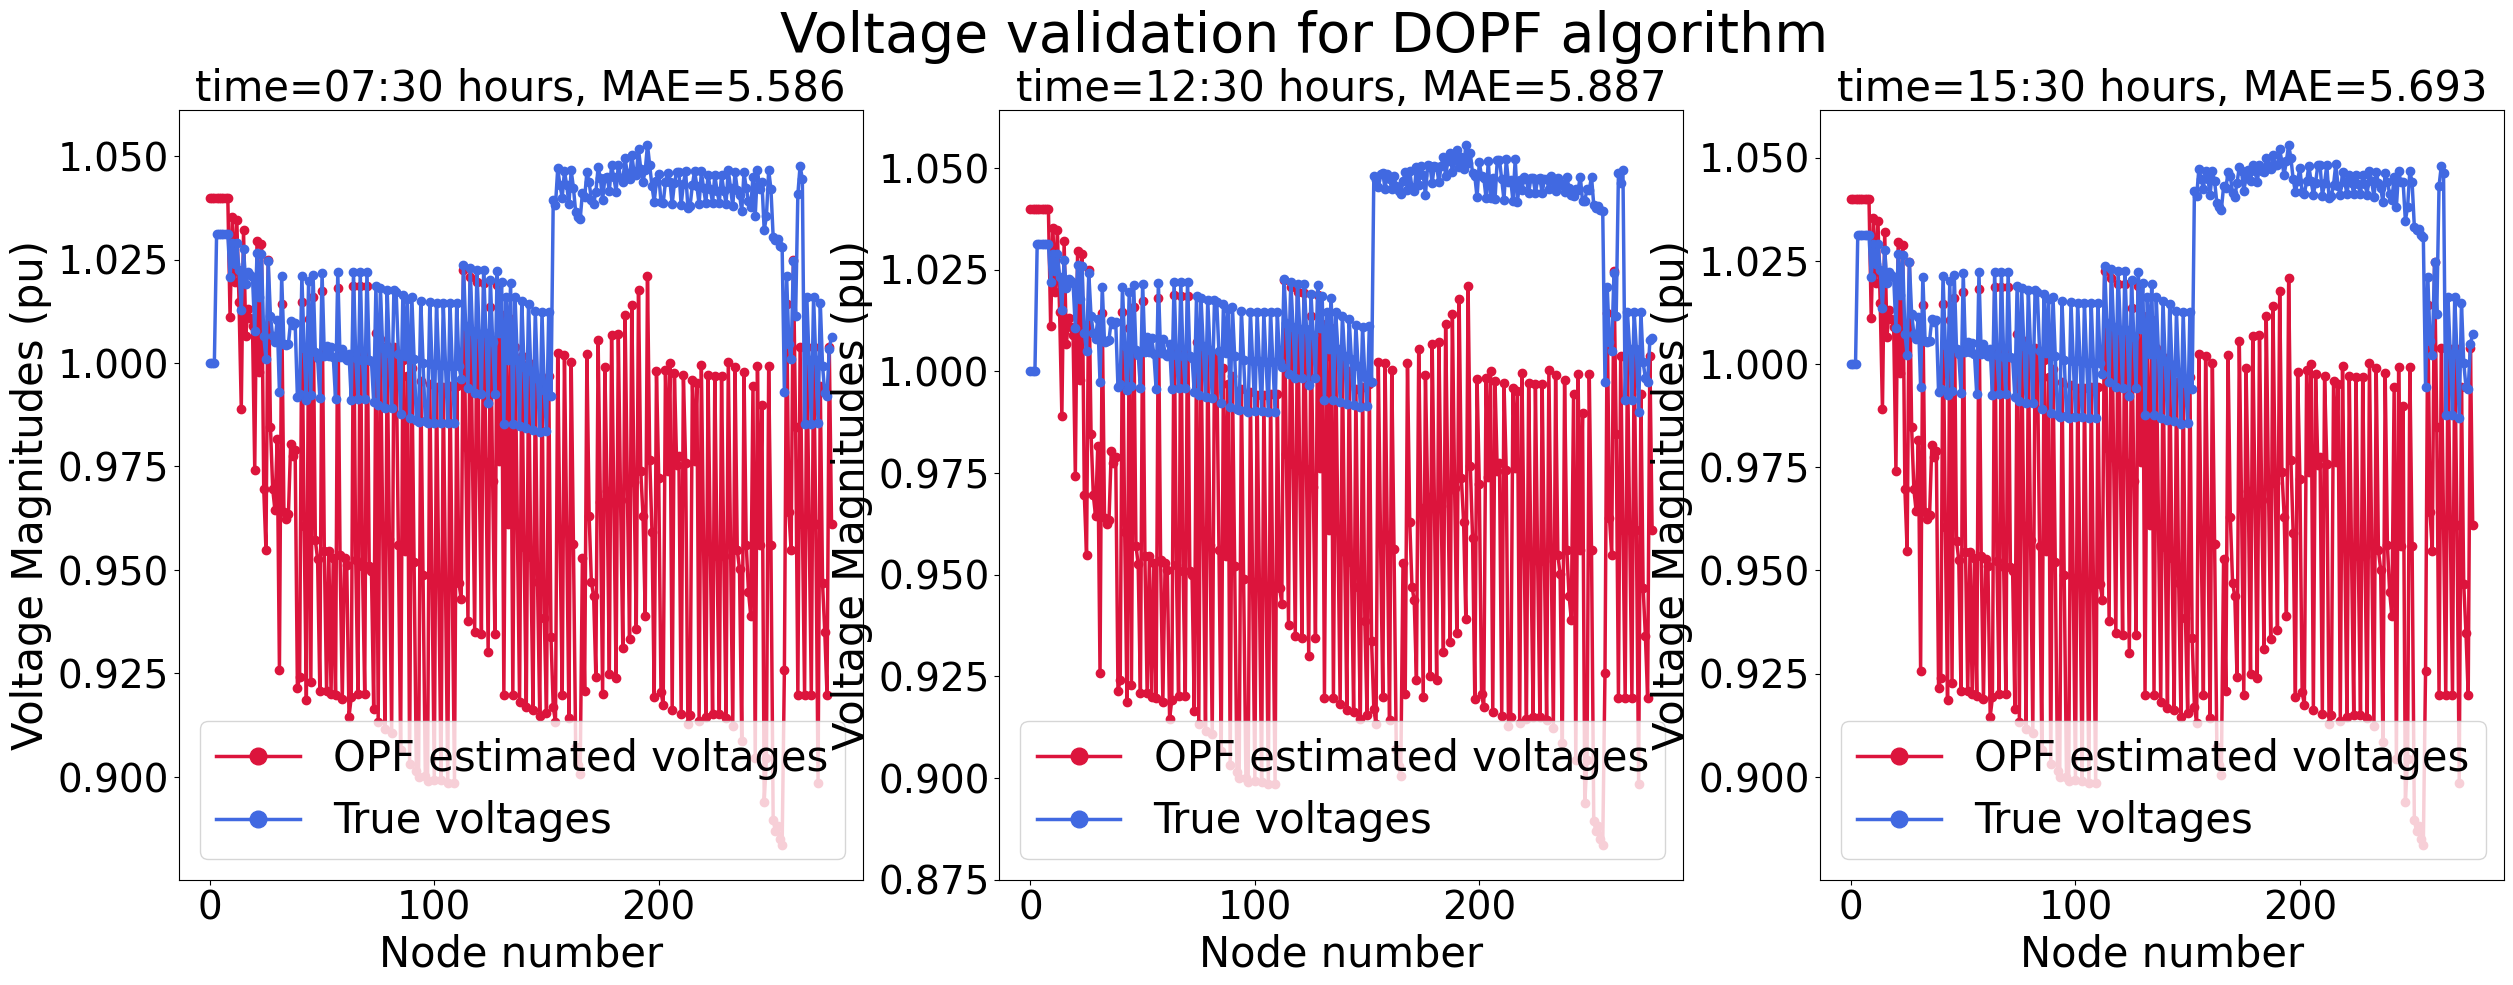

In [7]:
fig_filename = os.path.join(directory, f"voltage_comparison.png")
plotter.plot_opf_voltage_comparison(
    topology_filepath,
    real_voltage_filepath, 
    imag_voltage_filepath, 
    opf_voltage_filepath,
    time=time,
    show=True,
    to_file=fig_filename
)

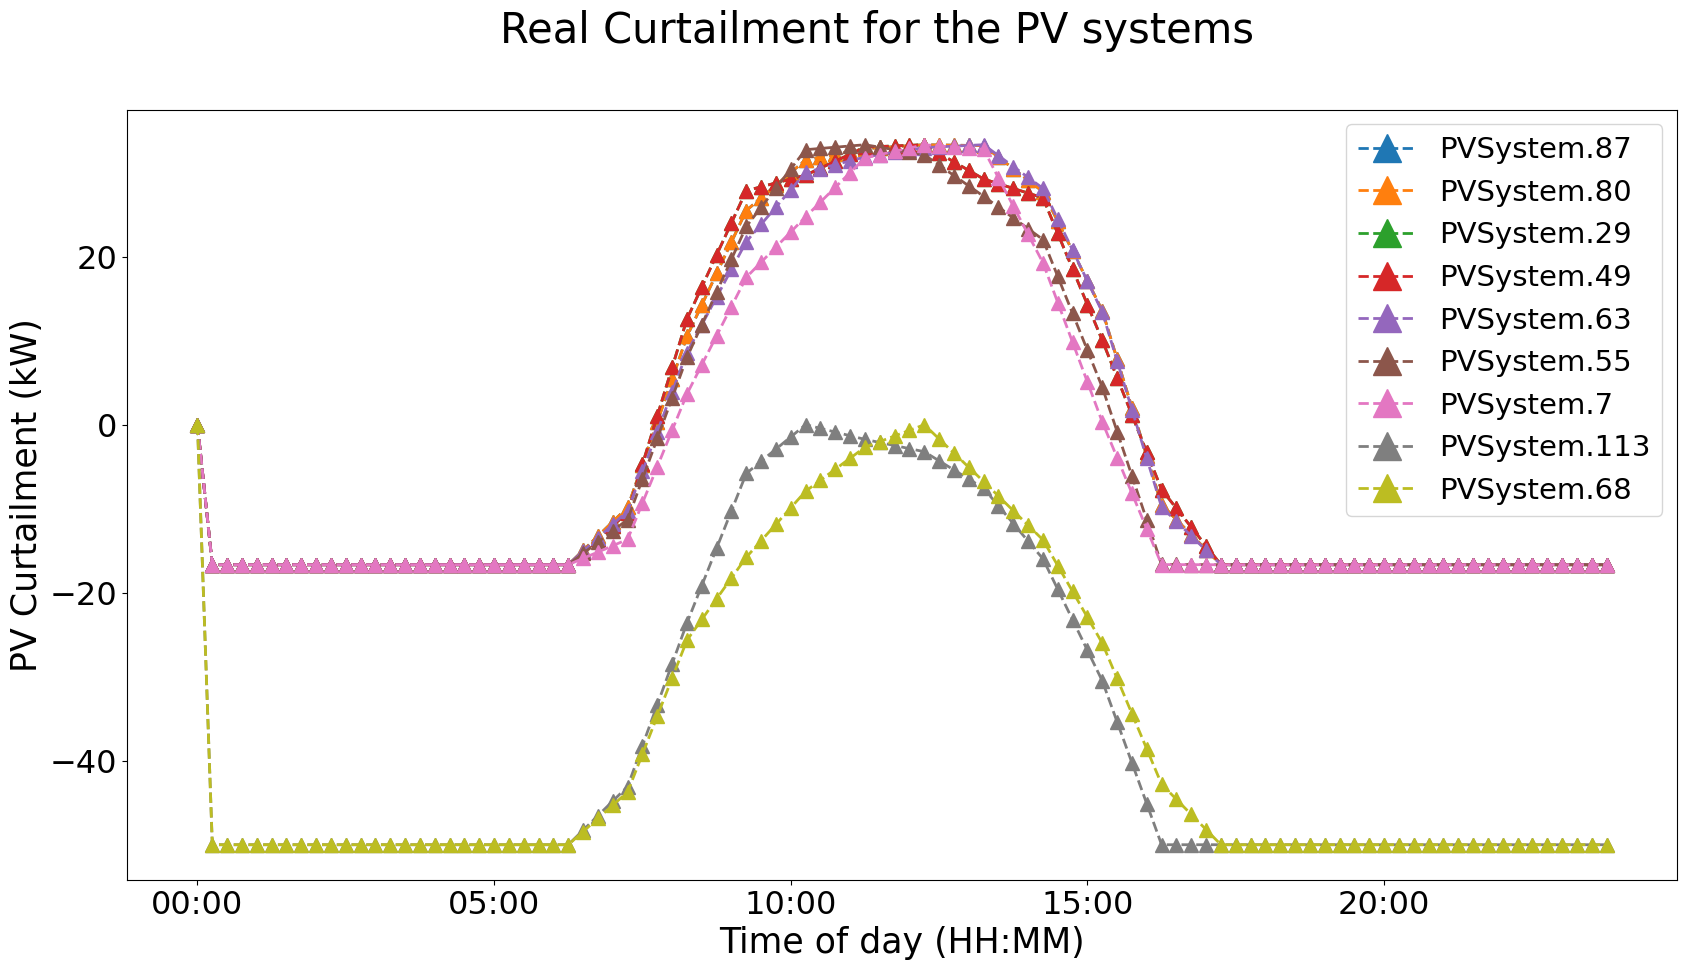

In [8]:

plotter.plot_curtail(real_curtail_filepath, suptitle_pfx="Real ")

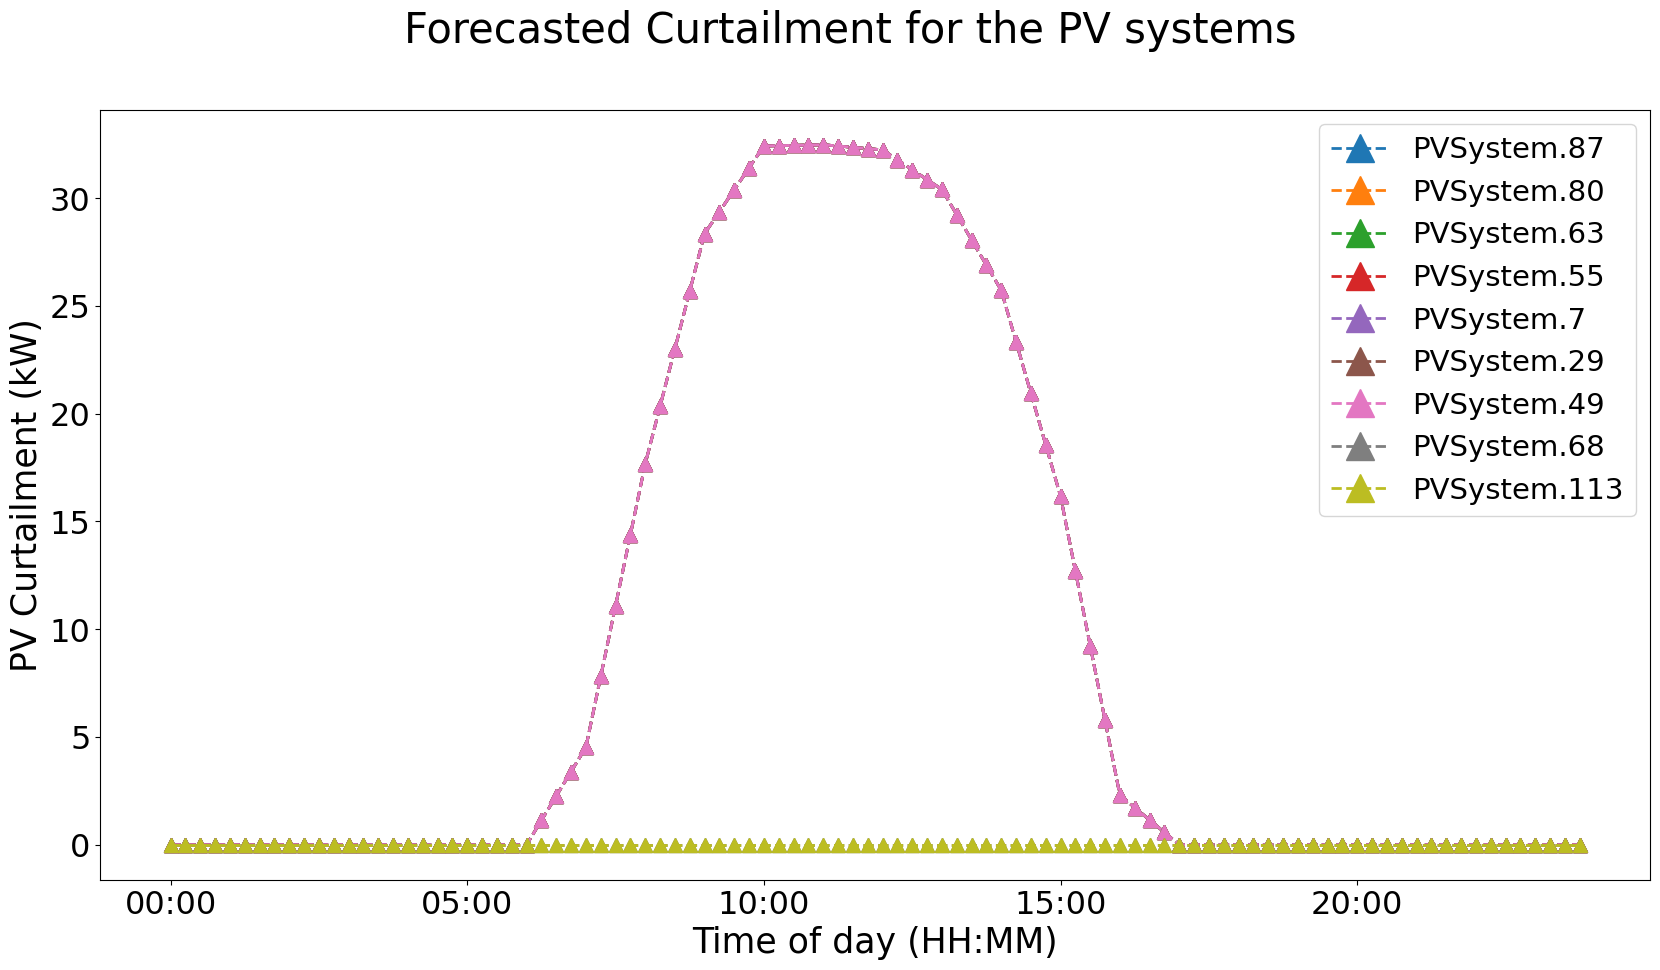

In [9]:
plotter.plot_curtail(forecast_curtail_filepath, suptitle_pfx="Forecasted ")